# Исследование пользователей мобильного приложения

**Описание:** <br>
Наш стартап продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Изучить воронку продаж:

- как пользователи доходят до покупки
- сколько пользователей доходит до покупки
- сколько и где «застревают» на предыдущих шагах

Провести исследование результатов A/A/B-эксперимента. <br>
Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Нужно выяснить, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, можно быть уверенным в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

## Предварительный анализ данных

**Описание данных:**

В нашем распоряжении логи мобильного приложения из файла logs_exp.csv <br>
Каждая запись в логе — это действие пользователя, или событие:

- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
import matplotlib.pyplot as plt
from scipy import stats as st
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)
pd.set_option('mode.chained_assignment', None)

In [2]:
# Выгрузка данных
try:
    logs = pd.read_csv('D:/Practicum/Аналитика данных/Сборный проект 2/Проект/logs_exp.csv', sep = '\t')
except:
    logs = pd.read_csv('https://code.s3.yandex.net/datasets/logs_exp.csv', sep = '\t')

In [3]:
# Просмотр основной информации о данных, пропусках и поиск возможных явных дубликатов
display(logs.head())
display(logs.info())
print(f'Кол-во пропусков: {logs.isna().sum()}')
print(f'Кол-во дубликатов: {logs.duplicated().sum()}')

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Кол-во пропусков: EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Кол-во дубликатов: 413


Пропусков в данных нет, однако есть места, где нужно навести порядок:
1. названия столбцов привести к snake case
2. преобразовать тип данных о времени
3. убрать дубликаты

## Предобработка данных

Приведем названия столбцов к snake case, а также добавим столбец даты и времени, а также отдельный столбец дат.

In [4]:
# переименовывание столбцов
logs = logs.rename(columns = \
               {'EventName':'event_name', 'DeviceIDHash':'user_id', 'EventTimestamp':'event_time', 'ExpId':'group'})

In [5]:
# приведение типа данных и добавление столбца с датой
logs['event_time'] = pd.to_datetime(logs['event_time'], unit='s')
logs['date'] = logs['event_time'].dt.date

In [6]:
# удаление дубликатов
logs = logs.drop_duplicates().reset_index(drop=True)

In [7]:
# переименуем обозначения кнотрольных групп
def rename_group(group):
    if group == 246:
        return 'A1'
    elif group == 247:
        return 'A2'
    elif group == 248:
        return 'B'
    else:
        return 'не определено'

logs['group'] = logs['group'].apply(rename_group)

In [8]:
# посмотрим, что получилось
display(logs.head())
display(logs.info())

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 9.3+ MB


None

Данные приведены в порядок и готовы к дальнейшему анализу.

## Анализ данных

Сначала определим сколько всего событий, сколько пользователей и сколько событий на пользователя в логе

In [9]:
print(f'Всего в логе {logs.event_name.count()} событий, {logs.user_id.nunique()} пользователей')
print(f'В среднем на пользователя приходится {int(len(logs) / logs.user_id.nunique())} события.')

Всего в логе 243713 событий, 7551 пользователей
В среднем на пользователя приходится 32 события.


Определим, данными за какой период мы располагаем. Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определим, с какого момента данные полные и отбросим более старые.

In [10]:
print(f'Период данных который у нас есть: {logs.event_time.min()} - {logs.event_time.max()}')
print(f'Период времени составляет: {logs.event_time.max() - logs.event_time.min()}')

Период данных который у нас есть: 2019-07-25 04:43:36 - 2019-08-07 21:15:17
Период времени составляет: 13 days 16:31:41


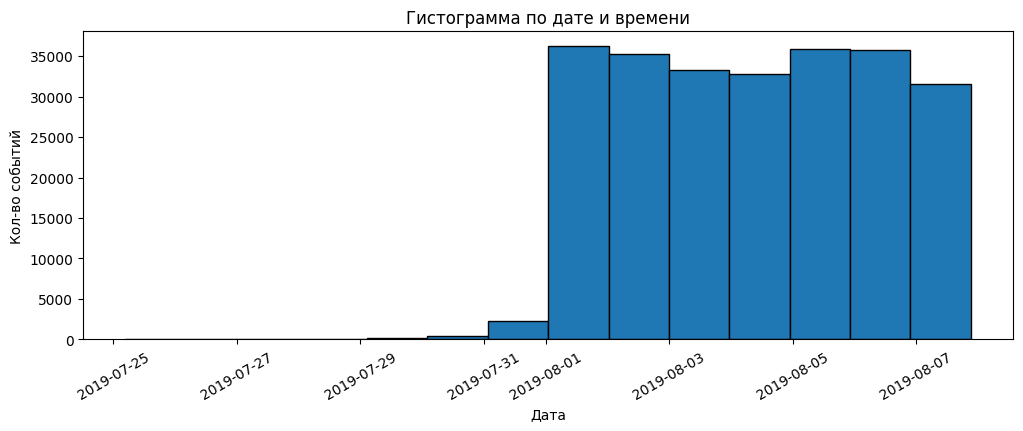

In [11]:
# Построим гистограмму
plt.figure(figsize = (12,4))
logs.event_time.hist(bins = logs.date.nunique(), edgecolor = 'black')
plt.title('Гистограмма по дате и времени')
plt.ylabel('Кол-во событий')
plt.xlabel('Дата')
plt.xticks(rotation = 30)
plt.grid()
plt.show()

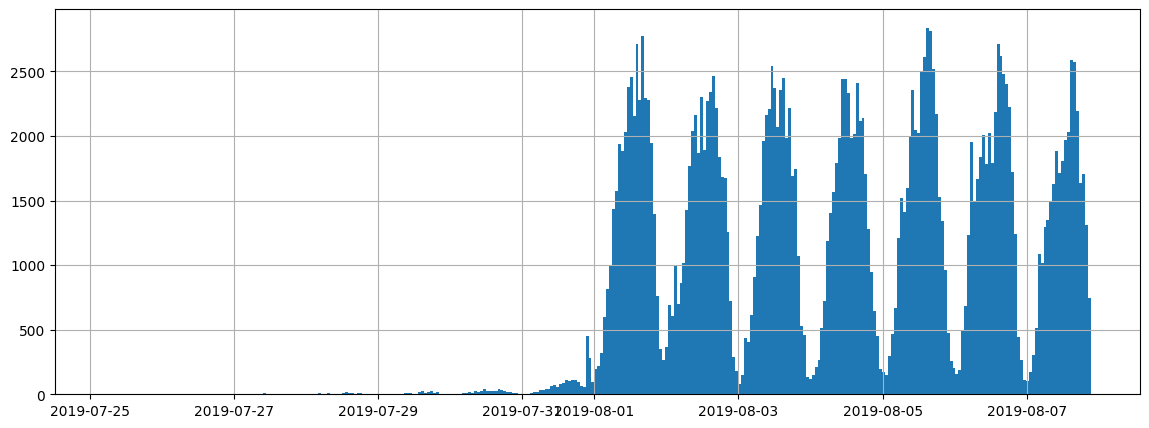

In [12]:
# код ревьюера
logs['event_time'].hist(bins=14*24, figsize=(14, 5));

В данных информация за две недели: с 25 июля по 7 августа 2019 года, однако видно, что 1 августа происходит резкий скачок количества событий, то есть в первую неделю данные неполные. Отфильтруем их.

In [13]:
logs_new = logs.query('date > datetime(2019, 7, 31).date()').reset_index(drop = True)
logs_new.sort_values(by = 'event_time').head()

,event_name,user_id,event_time,group,date
0,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01
1,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01
2,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01
3,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01
4,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01


Посмотрим, за какой период времени мы распологаем на самом деле.

In [14]:
print(f'Период данных который у нас есть: {logs_new.event_time.min()} - {logs_new.event_time.max()}')
print(f'Период времени составляет: {logs_new.event_time.max() - logs_new.event_time.min()}')

Период данных который у нас есть: 2019-08-01 00:07:28 - 2019-08-07 21:15:17
Период времени составляет: 6 days 21:07:49


Определим, сколько событий и пользователей теряется, если отбросить старые данные.

In [15]:
print(f'Всего в логе {logs.event_name.count()} событий, {logs.user_id.nunique()} пользователей до очистки')
print(f'Всего в логе {logs_new.event_name.count()} событий, {logs_new.user_id.nunique()} пользователей после очистки')
print(f'Потеря событий: {logs.event_name.count() - logs_new.event_name.count()}, '
      f'что составляет {(logs.event_name.count() - logs_new.event_name.count()) * 100 / logs.event_name.count()} %')
print(f'Потеря пользователей: {logs.user_id.nunique() - logs_new.user_id.nunique()}, '
      f'что составляет {(logs.user_id.nunique() - logs_new.user_id.nunique()) * 100 / logs.user_id.nunique()} %')

Всего в логе 243713 событий, 7551 пользователей до очистки
Всего в логе 240887 событий, 7534 пользователей после очистки
Потеря событий: 2826, что составляет 1.1595606307418973 %
Потеря пользователей: 17, что составляет 0.22513574361011787 %


После отчистки данных потери составляют около 1% событий и пользователей, это приемлемый результат. Далее определим, распределение пользователей по группам.

In [16]:
logs_new.groupby('group')['user_id'].nunique()

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

Проверим, есть ли пользователи, попавшие сразу в несколько групп теста.

In [17]:
duplicated_users = logs_new.groupby('user_id').agg({'group':'nunique'}).reset_index()
display(duplicated_users.head())
len(duplicated_users.query('group > 1'))

,user_id,group
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1


0

Даннные о пользователях имеются из всех трех экспериментальных групп, распределение примерно одинаковое. Нет пользователей, которые попали сразу в несколько групп.

**Выводы:**

Мы выяснили, что изначально в логе было 243713 событий и 7551 пользователей, определили период данных с 2019-07-25 04:43:36 по 2019-08-07 21:15:17. <br>
Однако только начиная с 1 августа данные можно считать полными, поэтому удалили часть данных за первую неделю. Отбросив старые данные мы потеряли 17 пользователей и 2826 событий (около 1%). <br>
При этом данные о пользователях есть из всех трёх экспериментальных групп, все пользователи находятся в рахных группах.

## Анализ воронки событий

Изучим, какие события и как часто встречаются в логах.

In [18]:
logs_new['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Всего 5 событий:

- *MainScreenAppear* - просмотр главной страницы
- *OffersScreenAppear* - просмотр страницы предложений
- *CartScreenAppear* - просмотр корзины
- *PaymentScreenSuccessful* - переход на страницу успешной оплаты
- *Tutorial* - просмотр обучающей информации для новых пользователей

Первые четыре события образуют последовательную цепочку движения пользователя по приложению. Обучение (Tutorial) не является обязательным этапом, что объясняет такое малое его количество в логах.

Посчитаем, сколько пользователей совершали каждое из этих событий.

In [19]:
events_hole = (
    logs_new.groupby('event_name')['user_id'].nunique()
    .sort_values(ascending = False)
    .to_frame()
    .reset_index()
)
events_hole.columns = ['event_name', 'total_users']

events_hole['%'] = (events_hole['total_users'] / logs_new['user_id'].nunique() * 100).round(2)
events_hole

,event_name,total_users,%
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


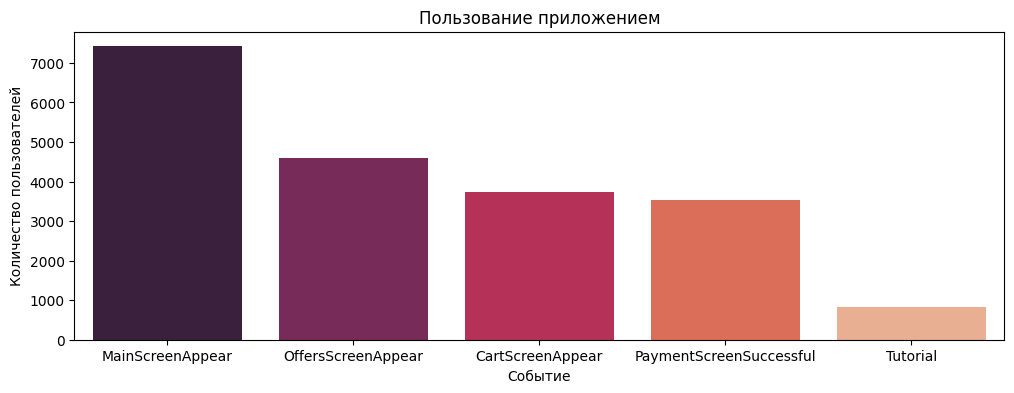

In [20]:
plt.figure(figsize = (12,4))
sns.barplot(y = 'total_users', x = 'event_name', data = events_hole, palette='rocket')
plt.title('Пользование приложением')
plt.xlabel('Событие')
plt.ylabel('Количество пользователей')
plt.show()

Если судить по количеству событий, то обучение должно быть в самом низу воронки, так как оно самое малочисленное, однако это не так. Обычно данное событие проходят (или пропускают) в самом начале для того, чтобы в дальнейшем было более понятно, как пользоваться приложением. Большинство пользователей предпочитают пропускать обучающие материалы и сразу переходят к действиям. Исходя из логики вещей имеем следующий порядок событий:

1. MainScreenAppear - главный экран
2. Tutorial - прохождение обучения по пользованию приложения (по желанию)
3. OffersScreenAppear - товар
4. CartScreenAppear - корзина
5. PaymentScreenSuccessful - успешная оплата заказа

При расчете воронки не стоит учитывать страницу обучения.

Узнаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем), на каком шаге теряеется больше всего пользователей и какая доля пользователей доходит от первого события до оплаты. 

In [21]:
# Для построения воронки исключаем обучение
events_hole = events_hole.query('event_name != "Tutorial"')
events_hole

,event_name,total_users,%
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [22]:
# построим воронку
events_hole['funnel, %'] = 100
for i in range(1, len(events_hole)):
    events_hole.loc[i, 'funnel, %'] = \
    ((events_hole.loc[i, 'total_users'] / (events_hole.loc[i - 1, 'total_users'])) * 100).round(1)
events_hole

,event_name,total_users,%,"funnel, %"
0,MainScreenAppear,7419,98.47,100.0
1,OffersScreenAppear,4593,60.96,61.9
2,CartScreenAppear,3734,49.56,81.3
3,PaymentScreenSuccessful,3539,46.97,94.8


По данным из воронки видно:

- первый шаг - 100%
- второй шаг - 61.9% от первого
- третий шаг - 81.3% от второго
- четвертый шаг - 94.8% от третьего

**Выводы:**

Больше всего пользователей теряется после просмотра главной страницы (38.1%). Возможно, отделу маркетинга стоит поработать с данным моментом, чтобы лучше удерживать потенциального покупателя. Чем дальше идет пользователь, тем он больше уверен в своем желании совершить покупку, так как проблем на шагах, следующих за главным экраном не наблюдается. Все же стоит обратить внимание, почему с предпоследнего шага оплаты до последнего успешной оплаты теряется 5.2% пользователей. Возможно, есть какие-то технические трудности при оплате или же клиент передумывает в последний момент о покупке. От первого события до оплаты доходит 47% пользователей приложения.

## Анализ результата эксперимента

Для анализа возьмем актуальные данные за вторую неделю. Посмотрим сколько пользователей в каждой экспериментальной группе.

In [23]:
logs_group = logs_new.groupby('group')['user_id'].nunique()
logs_group['A1A2'] = logs_group['A1'] + logs_group['A2']
logs_group

group
A1      2484
A2      2513
B       2537
A1A2    4997
Name: user_id, dtype: int64

Всего имеются три группы пользователей: группы A1 и A1 - контрольные, группа B - экспериментальная. В них по 2484, 2513 и 2537 человек соответственно.

**Проверим критерии успешного A/A теста:**

- Количество пользователей в различных группах различается не более, чем на 1% или 0.5%
- Для всех групп фиксируют и отправляют в системы аналитики данные об одном и том же
- Различие ключевых метрик по группам не превышает 1% и не имеет статистической значимости
- Попавший в одну из групп посетитель остаётся в этой группе до конца теста. Если пользователь видит разные версии исследуемой страницы в ходе одного исследования, неизвестно, какая именно повлияла на его решения. Значит, и результаты такого теста нельзя трактовать однозначно.

In [24]:
print(f'Разница между группой A1 и A2 составляет: {round((100 - (logs_group.A1 / logs_group.A2 * 100)), 2)} %')

Разница между группой A1 и A2 составляет: 1.15 %


Группы отличаются по количеству более, чем на 1%. Проверить, как зафиксированы и отправлены данные, мы не можем, поэтому будем полагаться на источник наших данных. Среди пользователей нет тех, кто одновременно попал в разные группы. Остается проверить различие ключевых метрик и статистическую значимость.

Посчитаем число пользователей, совершивших самое популярное событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [25]:
# Создадим таблицу с количеством пользователей из каждой группы с разбивкой по шагам воронки
logs_per_event = logs_new.query('event_name != "Tutorial"').pivot_table(
    index = 'event_name', 
    columns = 'group', 
    values = 'user_id',
    aggfunc = 'nunique').sort_values(by = 'B', ascending = False)

logs_per_event['A1A2'] = logs_per_event['A1'] + logs_per_event['A2']
logs_per_event['all'] = logs_per_event['A1A2'] + logs_per_event['B']
logs_per_event

group,A1,A2,B,A1A2,all
event_name,,,,,
MainScreenAppear,2450,2476,2493,4926,7419
OffersScreenAppear,1542,1520,1531,3062,4593
CartScreenAppear,1266,1238,1230,2504,3734
PaymentScreenSuccessful,1200,1158,1181,2358,3539


In [26]:
# Добавим доли пользователей из каждой группы с разбивкой по шагам воронки
logs_per_event['part_A1'] = (logs_per_event['A1'] / logs_group['A1'] * 100).round(2)
logs_per_event['part_A2'] = (logs_per_event['A2'] / logs_group['A2'] * 100).round(2)
logs_per_event['part_B'] = (logs_per_event['B'] / logs_group['B'] * 100).round(2)
logs_per_event['part_A1A2'] = ((logs_per_event['A1A2']) / \
                               (logs_group['A1'] + logs_group['A2']) * 100).round(2)
logs_per_event

group,A1,A2,B,A1A2,all,part_A1,part_A2,part_B,part_A1A2
event_name,,,,,,,,,
MainScreenAppear,2450,2476,2493,4926,7419,98.63,98.53,98.27,98.58
OffersScreenAppear,1542,1520,1531,3062,4593,62.08,60.49,60.35,61.28
CartScreenAppear,1266,1238,1230,2504,3734,50.97,49.26,48.48,50.11
PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.31,46.08,46.55,47.19


Судя по воронке данных всех трех групп очень близки по значениям.

Задача сравнения пропорций двух генеральных совокупностей по выборкам из них - z-тест.

Сформулируем гипотезы:

- **H0:** Cтатистически значимых различий в конверсии между группами нет
- **H1:** Cтатистически значимые различия в конверсии между группами есть

Напишем отдельную функцию для проверки статистически значимой разницы для всех событий и узнаем корректно ли разбиение на группы. Важно учесть поправку Бонферрони для уменьшения вероятности ошибиться, так как имеем дело с множественным сравнением. Всего проводим 4 А/А-теста и 12 А/В-тестов.

In [27]:
def z_test(group1, group2, event, alpha=0.05): 
    
    p1_event = logs_per_event[group1][event]
    p2_event = logs_per_event[group2][event]
    
    p1_users = logs_group.loc[group1] 
    p2_users = logs_group.loc[group2] 
    
    # пропорция успехов в первой группе:
    p1 = p1_event / p1_users 
    # пропорция успехов во второй группе
    p2 = p2_event / p2_users 
    
    # пропорция успехов в комбинированном датасете
    p_combined = (p1_event + p2_event) / (p1_users + p2_users) 
    
    # разница пропорций в датасетах
    difference = p1 - p2
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_users + 1 / p2_users))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # введем поправку Бонферрони, поделим альфа на число гипотез для всех проверок
    # всего проверок: 4(кол-во событий) * 4(кол-во попарных проверок: A1-A2, A1-B, A2-B, (A1+A2-B)) = 16
    bonferroni_alpha = alpha / 16
    
    print('Проверка для групп {} и {}, событие: {}, p-значение: {p_value:.2f}'.\
          format(group1, group2, event, p_value = p_value))
    
    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу о равенстве данных в группах")
    else:
        print("Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах")

Проверим, находят ли статистические критерии разницу между выборками А1 и А2.

In [28]:
for event in logs_per_event.index:
    z_test('A1', 'A2', event)
    print('-' * 70)

Проверка для групп A1 и A2, событие: MainScreenAppear, p-значение: 0.76
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1 и A2, событие: OffersScreenAppear, p-значение: 0.25
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1 и A2, событие: CartScreenAppear, p-значение: 0.23
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1 и A2, событие: PaymentScreenSuccessful, p-значение: 0.11
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------


**Вывод:** разбивка на группы работает корректно, несмотря на отличия между группами. Нет статистически значимой разницы для всех событий воронки продаж в группах A1 и A2.

Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.

In [29]:
for event in logs_per_event.index:
    z_test('A1', 'B', event)
    print('-' * 70)

Проверка для групп A1 и B, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1 и B, событие: OffersScreenAppear, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1 и B, событие: CartScreenAppear, p-значение: 0.08
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1 и B, событие: PaymentScreenSuccessful, p-значение: 0.21
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------


**Вывод:** Нет статистически значимой разницы для всех событий воронки продаж в группах A1 и B.

In [30]:
for event in logs_per_event.index:
    z_test('A2', 'B', event)
    print('-' * 70)

Проверка для групп A2 и B, событие: MainScreenAppear, p-значение: 0.46
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A2 и B, событие: OffersScreenAppear, p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A2 и B, событие: CartScreenAppear, p-значение: 0.58
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.74
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------


**Вывод:** Нет статистически значимой разницы для всех событий воронки продаж в группах A2 и B.

Сравним результаты с объединённой контрольной группой.

In [31]:
for event in logs_per_event.index:
    z_test('A1A2', 'B', event)
    print('-' * 70)

Проверка для групп A1A2 и B, событие: MainScreenAppear, p-значение: 0.29
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1A2 и B, событие: OffersScreenAppear, p-значение: 0.43
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1A2 и B, событие: CartScreenAppear, p-значение: 0.18
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------
Проверка для групп A1A2 и B, событие: PaymentScreenSuccessful, p-значение: 0.60
Не получилось отвергнуть нулевую гипотезу о равенстве данных в группах
----------------------------------------------------------------------


**Вывод:** Нет статистически значимой разницы для всех событий воронки продаж в группах A1A2(объединение двух контрольных групп) и B.

## Итоги:

Необходимо было проанализировать конверсию пользователей в приложении и изучить результаты А/А/В-теста, в котором 2 контрольные(A1 и A2) группы видели версию приложения со старыми шрифтами, а экспериментальная(B) с новыми и нужно было понять, как это изменение отразиться но поведении пользователей.

Пропущенных значений в исходных даных не было, дубликаты были удалены, названия столбцов переименованы, добавлены новые столбцы с датами, приведены типы данных, изменены названия тестовых групп. 

После обработки данных мы потеряли всего около 1% данных по событиям и пользователям. 

Анализ воронки продаж выявил: 

- событие Tutorial(обучение) самое невостребованное, то есть большинство пользователей его просто игнорируют.
- с первого шага до последнего доходят только 48% клиентов, что в принципе неплохо
- больше всего пользователей мы теряем при переходе с главного экрана к продуктам - 38.1% (тут явно есть над чем поработать)
- на последнем шаге теряется 5.2% пользователей, возможно есть какие-то технические трудности при оплате или же потребитель передумывает в последний момент о покупке

Группы для А/А/В-тестов были корректными, несмотря на разницу чуть больше рекомендованого 1% между контрольными группами А1 и А2 в количестве пользователей. При проверке статистических гипотез выбрали уровень значимости равный 5%, применяя поправку Бонферрони, так как работали с множественным сравнением.

По результатам теста не было выявлено различий между контрольными и эксперементальной группами, что говорит о том, что замена шрифтов никак не повлияла на пользователей. Опасения менеджеров, что пользователям будет непривычно не оправдались.